In [1]:
import random
import json
import gym
from gym import spaces
import pandas as pd
import numpy as np

MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 5000
MAX_STEPS = 20000

INITIAL_ACCOUNT_BALANCE = 10000


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    def __init__(self, df):
        super(StockTradingEnv, self).__init__()

        self.df = df
        self.reward_range = (0, MAX_ACCOUNT_BALANCE)

        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(
            low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)

        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(6, 6), dtype=np.float16)

    def _next_observation(self):
        # Get the stock data points for the last 5 days and scale to between 0-1
        frame = np.array([
            self.df.loc[self.current_step: self.current_step +
                        5, 'Open'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step: self.current_step +
                        5, 'High'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step: self.current_step +
                        5, 'Low'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step: self.current_step +
                        5, 'Close'].values / MAX_SHARE_PRICE,
            self.df.loc[self.current_step: self.current_step +
                        5, 'Volume'].values / MAX_NUM_SHARES
        ])

        # Append additional data and scale each value to between 0-1
        # print(self.current_step)
        # print(frame.shape)
        obs1 = np.append(frame, [[
            self.balance / MAX_ACCOUNT_BALANCE,
            self.max_net_worth / MAX_ACCOUNT_BALANCE,
            self.shares_held / MAX_NUM_SHARES,
            self.cost_basis / MAX_SHARE_PRICE,
            self.total_shares_sold / MAX_NUM_SHARES,
            self.total_sales_value / (MAX_NUM_SHARES * MAX_SHARE_PRICE),
        ]], axis=0)
        obs =obs1
        return obs

    def _take_action(self, action):
        # Set the current price to a random price within the time step
        current_price = random.uniform(
            self.df.loc[self.current_step, "Open"], self.df.loc[self.current_step, "Close"])

        action_type = action[0]
        amount = action[1]

        if action_type < 1:
            # Buy amount % of balance in shares
            total_possible = int(self.balance / current_price)
            shares_bought = int(total_possible * amount)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * current_price

            self.balance -= additional_cost
            self.cost_basis = (
                prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

        elif action_type < 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held * amount)
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price

        self.net_worth = self.balance + self.shares_held * current_price

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        if self.shares_held == 0:
            self.cost_basis = 0

    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)

        self.current_step += 1

        if self.current_step > len(self.df.loc[:, 'Open'].values) - 6:
            self.current_step = 0

        delay_modifier = (self.current_step / MAX_STEPS)

        reward = self.balance * delay_modifier
        done = self.net_worth <= 0

        obs = self._next_observation()

        return obs, reward, done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        # Set the current step to a random point within the data frame
        self.current_step = random.randint(
            0, len(self.df.loc[:, 'Open'].values) - 6)

        return self._next_observation()

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(
            f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(
            f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(
            f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
        print(f'Profit: {profit}')

In [4]:
import yfinance as yf  #0.2.22

x = "NVDA"

data = yf.Ticker(x).history(period="1y")  #1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
data.index = data.index.strftime("%Y-%m-%d")
data["t"] = range(len(data))
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,t
Date,,,,,,,,
2022-07-25,170.049434,171.098570,166.352493,170.099396,48074800,0.0,0.0,0
2022-07-26,168.750524,169.050279,164.643917,165.193466,39786500,0.0,0.0,1
2022-07-27,170.179341,179.211868,168.990321,177.753067,56977600,0.0,0.0,2
2022-07-28,179.601561,181.250192,174.255973,179.691483,47464600,0.0,0.0,3
2022-07-29,177.982901,182.289340,176.773894,181.480011,43546000,0.0,0.0,4


In [15]:
import gym
import json
import datetime as dt

# from stable_baselines3.common.policies import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO
#import talib as ta

import pandas as pd

df = data.reset_index()

# The algorithms require a vectorized environment to run
env = StockTradingEnv(df)
#env = DummyVecEnv([lambda: StockTradingEnv(df)])

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100)

obs = env.reset()
for i in range(2000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/mdp/opt/anaconda3/envs/rl/lib/python3.8/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


TypeError: cannot do slice indexing on Index with these indexers [67] of type int

In [53]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as data_reader

from tqdm import tqdm_notebook, tqdm
from collections import deque


class AI_Trader():
    
    def __init__(self, state_size, action_space=3, model_name="AITrader"):
        self.state_size = state_size
        self.action_space = action_space
        self.memory = deque(maxlen=2000)
        self.inventory = []
        self.model_name = model_name
        self.gammsa = 0.95
        self.epsilon = 1.0
        self.epsilon_final = 0.01
        self.epsilon_decay = 0.995
    
    def model_builder(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(units=32, activation='relu', input_dim=self.state_size))
        model.add(tf.keras.layers.Dense(units=64, activation='relu'))
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        model.add(tf.keras.layers.Dense(units=self.action_space, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizer.Adam(lr=0.001))
        return model

    def trade(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_space)
        actions = self.model.predict(actions[0])

    def batch_train(self, batch_size):
        batch = []
        for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
          batch.append(self.memory[i])
        for state, action, reward, next_state, done in batch:
          reward = reward
          if not done:
            reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
          target = self.model.predict(state)
          target[0][action] = reward
          self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_final:
          self.epsilon *= self.epsilon_decay

In [54]:
def sigmoid(x):
    return (1 + math.exp(-x))

def stock_price_format(n):
    if n < 0:
        return "- # {0:2f}".format(abs(n))
    else:
        return "$ {0:2f}".format(abs(n))

def dataset_loader(stock_name):
    dataset = data_reader.DataReader(stock_name, data_source="yahoo")
    start_date = str(dataset.index[0]).split()[0]
    end_date = str(dataset.index[1]).split()[0]
    close = dataset['Close']
    return close

def state_creator(data, timestep, window_size):
    starting_id = timestep - window_size + 1
    if starting_id >= 0:
        windowed_data = data[starting_id:timestep+1]
    else:
        windowed_data = starting_id * [data[0]] + list(data[0:timestep+1])
    state = []
    for i in range(window_size - 1):
        state.append(sigmoid(windowed_data[i+1] - windowed_data[i]))
    return np.array([state])

In [58]:
window_size = 10
episodes = 1000

batch_size = 32
data_samples = len(data) - 1

trader = AI_Trader(window_size)

In [59]:
for episode in range(1, episodes + 1):
    print("Episode: {}/{}".format(episode, episodes))
    state = state_creator(data, 0, window_size + 1)
    total_profit = 0
    trader.inventory = []
    
    for t in tqdm(range(data_samples)):
        action = trader.trade(state)
        next_state = state_creator(data, t+1, window_size + 1)
        reward = 0
    
        if action == 1: #Buying
            trader.inventory.append(data[t])
            print("AI Trader bought: ", stocks_price_format(data[t]))
      
        elif action == 2 and len(trader.inventory) > 0: #Selling
            buy_price = trader.inventory.pop(0)
            reward = max(data[t] - buy_price, 0)
            total_profit += data[t] - buy_price
            print("AI Trader sold: ", stocks_price_format(data[t]), 
                  " Profit: " + stocks_price_format(data[t] - buy_price) )
      
        if t == data_samples - 1:
            done = True
        else:
            done = False
        
        trader.memory.append((state, action, reward, next_state, done))
        state = next_state
        
        if done:
            print("########################")
            print("TOTAL PROFIT: {}".format(total_profit))
            print("########################")
        
        if len(trader.memory) > batch_size:
            trader.batch_train(batch_size)

Episode: 1/1000


KeyError: 0

/Users/mdp/opt/anaconda3/envs/rl/lib/python3.8/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment TradingEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/mdp/opt/anaconda3/envs/rl/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/Users/mdp/opt/anaconda3/envs/rl/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/Users/mdp/opt/anaconda3/envs/rl/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form 

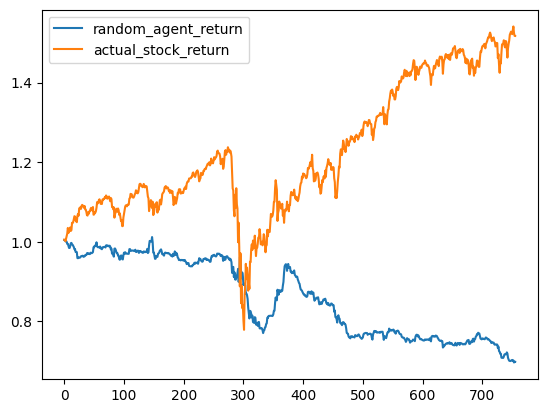

In [63]:
import gym
from gym.envs.registration import register
from gym import error, spaces, utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import arrow
import random
import sys

class TradingEnv(gym.Env):
    def __init__(self, start_date, end_date, tc=0.05/100, ticker='^DJI'):
        self.start = start_date
        self.end = end_date
        self.tc = tc
        self.ticker = ticker

        self.action_space = spaces.Discrete(1)
        self.observation_space = spaces.Box(low=-1,high=1,dtype=np.float32)
        returns = self.load_dataset()
        self.data_df = self.create_features(returns)
        self.curr_index = 0
        self.data_len = self.data_df.shape[0]
        self.action = 0

    def step(self, action):
        done = False
        stock_return = self.extract_return(self.data_df, self.curr_index)
        change_in_position = np.abs(self.action - action)
        cost = change_in_position * self.tc
        reward = action*stock_return - cost

        if self.curr_index == self.data_len - 2:
            done = True
        self.curr_index += 1
        self.action = action

        obs = self.extract_state(self.data_df, self.curr_index).values

        info = { 'date' : self.data_df.index[self.curr_index], 'return' : stock_return }

        return obs, reward, done, info

    def reset(self):
        self.curr_index = 0
        return self.extract_state(self.data_df, self.curr_index).values

    def render(self,mode='human'):
        pass

    def extract_return(self, df, i):
        return df.iloc[i]['Y']

    def extract_state(self, df, i):
        return df.iloc[i][['r%d' % i for i in range(5)]]

    def load_dataset(self):
        df = web.DataReader(self.ticker, 'stooq')
        mask = ( self.start <= df.index ) & ( df.index <= self.end )
        df = df[mask]
        df = df.sort_values(by='Date')
        returns = df['Close'].pct_change()
        return returns

    def create_features(self, returns):
        dfs = []
        for i in range(5):
            dfs.append(returns.shift(i).rename('r%d'%i))
        dfs.append(returns.shift(-1).rename('Y'))
        df_net = pd.concat(dfs, axis=1)
        df_net = df_net.dropna()
        return df_net

ENV_NAME = 'TradingEnv-v0'
reg = register(id=ENV_NAME, entry_point='__main__:TradingEnv', kwargs={'start_date':'2019-01-01', 'end_date':'2022-01-10'})

if __name__ == '__main__':
    env = gym.make(ENV_NAME)
    obs = env.reset()
    done = False
    reward_returns = []
    while not done:
        action = random.uniform(-1,1)
        obs, reward, done, info = env.step(action)
        reward_returns.append( (reward,info['return']) )
        
    i = list(range(len(reward_returns)))
    agent_returns = np.cumprod([ 1 + x[0] for x in reward_returns ])
    stock_returns = np.cumprod([ 1 + x[1] for x in reward_returns ])

    plt.plot(i, agent_returns, label='random_agent_return')
    plt.plot(i, stock_returns, label='actual_stock_return')
    plt.legend()
    plt.show()

In [68]:
class StockEnvTrain(gym.Env):
    metadata = {'render.modes':['human']}
    def __init__(self, df, day = 0):
        self.day = day
        self.df = df
        self.action_space = spaces.Box(low = -1, high = 1, shape = (STOCK_DIM,))
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (181,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False 
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
        self.data.adjcp.values.tolist() + \
        [0]*STOCK_DIM + \
        self.data.macd.values.tolist() + \
        self.data.rsi.values.tolist() + \
        self.data.cci.values.tolist() + \
        self.data.adx.values.tolist()
        # initialize reward
        self.reward = 0
        self.cost = 0
        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        self.trades = 0
        #self.reset()
        self._seed()